In [116]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Data Untuk Kondisi Lingkungan (Atmosfer)
g = 9.81                        # Percepatan gravitasi (m/s^2)
M_atm = 28.6                    # Massa molar udara atmosfer (g/mol)
P_ref = 1                       # Tekanan atmosfer di permukaan (atm)
rho_atm_ref = 1.225             # Massa jenis udara di permukaan bumi (g/L)T
T_atm_ref = 288.16              # Suhu udara di permukaan bumi (15 deg.C dalam K)
v_atm_ref = M_atm/rho_atm_ref   # Volume molar udara di permukaan bumi (L/mol)
a_atm = 1.33                    # Koreksi tekanan Van der Waals udara (atm.L^2/mol^2)
b_atm = 0.0366                  # Koreksi volume Van der Waals udara (L/mol)
R = 0.082057                    # Konstanta gas ideal (L.atm/mol.K)
alpha = 6.5*10**-3              # Laju penurunan suhu (deg.C/m)

# Data untuk Kondisi Perubahan Fasa Air
M_H2O = 18.01528                # Massa molar H2O ()
rho_liq = 1000                  # Massa jenis H2O dalam fasa cair (g/L)
rho_vap_ref = 0.6               # Massa jenis H2O dalam fasa gas pada tekanan 1 atm (g/L)
a_H2O = 5.537*0.968             # Koreksi tekanan Van der Waals H2O (atm.L^2/mol^2)
b_H2O = 0.03049                 # Koreksi volume Van der Waals H2O (L/mol)
l = 4.08*10**4                  # Kalor laten uap molar untuk air (J/mol)
T_boil_ref = 373.16             # Titik didih air di permukaan bumi (100 deg.C dalam K)
v_vap_ref = M_H2O/rho_vap_ref   # Volume molar uap air di permukaan bumi

In [117]:
# Fungsi Temperatur
def T(z) :
    y = T_atm_ref - alpha*z
    return y

# Fungsi volume molar udara atmnosfer berdasarkan Tekanan dan Ketinggian
def v_atm(P_atm) :
    def f(v) :
        y = P_atm*v**3-(R*Temp+b_atm)*v**2+a_atm*v-a_atm*b_atm
        return y
    v_guess = 10**6
    v_root = 0
    E = f(v_guess)
    dv = 10**-5
    e = 10**-3
    while E > e :
        v_root = v_guess-f(v_guess)*dv/(f(v_guess+dv)-f(v_guess))
        E = f(v_root)
        v_guess = v_root
    return v_root

# Fungsi massa jenis uap air atmnosfer berdasarkan Tekanan dan Ketinggian
def rho_vap(P_atm) :
    def v_vap(P_atm) :
        def f(v) :
            y = P_atm*v**3-(R*Temp+b_H2O)*v**2+a_H2O*v-a_H2O*b_H2O
            return y
        v_guess = 10**6
        v_root = 0
        E = f(v_guess)
        dv = 10**-5
        e = 10**-3
        while E > e :
            v_root = v_guess-f(v_guess)*dv/(f(v_guess+dv)-f(v_guess))
            E = f(v_root)
            v_guess = v_root
        return v_root
    x = M_H2O/v_vap(P_atm)
    return x

In [118]:
# hasil model

# Data awal
P_atm = P_ref
P_atm_show = P_atm*1013.25
Temp = T_atm_ref
T_boil = T_boil_ref
T_boil_show = T_boil - 273.16
z = 0

# Matriks data
p = [P_atm_show]
h = [z]
t = [T_boil_show]

# Iterasi ketinggian
dz = 10
z_max = 1*10**4
while z < z_max :
    # Perubahan ketinggian
    z += dz

    # Perubahan temperatur udara
    Temp = T(z)

    # Perubahan Tekanan dan Titik Didih
    dP_atm = -M_atm/v_atm(P_atm)*g*dz/(1.013*10**5)
    dT_boil = (M_atm*M_H2O*g*T_boil*(1/rho_liq-1/rho_vap(P_atm)))/(v_atm(P_atm)*l)*dz*10**-3

    # Update Nilai kondisi
    P_atm += dP_atm
    P_atm_show = P_atm*1013.25
    T_boil += dT_boil
    T_boil_show += dT_boil

    # Memasukkan data
    p.append(P_atm_show)
    h.append(z)
    t.append(T_boil_show)

In [119]:
# hasil gas ideal

# Generate data gas ideal
p_teori = np.zeros(len(h))
miss_P = np.zeros(len(h))
def P_teori_show(z):
    y = 1013.25*P_ref*(((T_atm_ref-alpha*z)/T_atm_ref)**(g*M_atm/(alpha*R*1000*101.325)))
    return y
t_teori = np.zeros(len(h))
miss_t = np.zeros(len(h))
def T_boil_teori(P):
    y = T_boil_ref*math.exp(M_H2O*((1/rho_vap_ref)-(1/rho_liq))*(P-P_ref)*101.325/l) - 273.16
    return y
for i in range(len(h)):
    p_teori[i]=P_teori_show(h[i])
    miss_P[i]=p[i]-p_teori[i]
    t_teori[i]=T_boil_teori(p_teori[i]/1013.25)
    miss_t[i]=t[i]-t_teori[i]

In [120]:
# hasil real data model
# temperatur terhadap ketinggian model nasa https://www.grc.nasa.gov/www/k-12/airplane/atmosmet.html
def T_nasa_model(h):
    if(h<11000): # troposfer
        return 15.04 - 0.00649 * h
    if(h<25000): # lower stratosphere
        return -56.46
    return -131.21 + 0.00299 * h # upper stratosphere

def kPa_to_mBar(pa):
    return pa*10
def mBar_to_kPa(mbar):
    return mbar/10

def p_nasa_model(h):
    if(h<11000): # troposfer
        return kPa_to_mBar(101.29 * ((T_nasa_model(h) + 273.1)/288.08)**5.256)
    if(h<25000): # lower stratosphere
        return kPa_to_mBar(22.65 * math.exp(1.73 - 0.000157 * h))
    return kPa_to_mBar(2.488 * ((T_nasa_model(h) + 273.1)/ 216.6)**-11.388) # upper stratosphere

# tekanan uap thdp temperatur dr Dean & Lange 1999, p. 1436 https://en.wikipedia.org/wiki/Water_(data_page)
def p_dean_model(t):
    if(t<273 - 273.16):
        raise Exception("out of model")
    if(t<333 - 273.16):
        return kPa_to_mBar(10 ** ((7.2326) - 1750.286/(t + 273.16 - 38.1)))
    if(t<423 - 273.16):
        return kPa_to_mBar(10 ** (7.0917 - 1668.21 / (t + 273.16 - 45.1)))
    raise Exception("out of model")

#invers of above (for 333<t<423 in Kelvin)
def t_dean_model_60up(p):
    return 1668.21/(7.0917 - math.log10(mBar_to_kPa(p))) + 45.1 - 273.16

T_nasa = []
p_nasa = []
T_model = []
for i in range(len(h)):
    T_nasa.append(T_nasa_model(h[i]))
    T_model.append(T(h[i]) - 273.16) # in celcius

    p_nasa.append(p_nasa_model(h[i]))

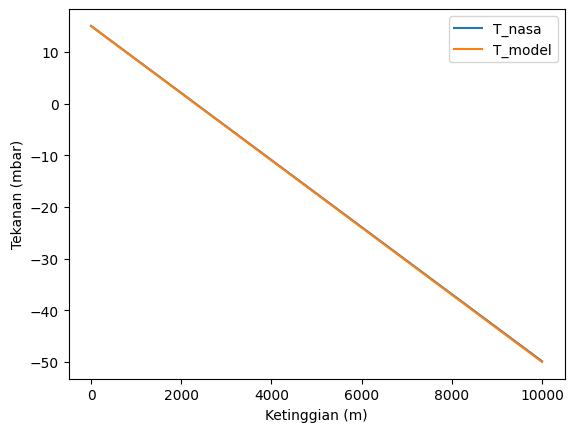

In [121]:
# T against height for 10 km
plt.plot(h,T_nasa, label = "T_nasa")
plt.plot(h,T_model, label = "T_model")
plt.xlabel("Ketinggian (m)")
plt.ylabel("Tekanan (mbar)")
plt.legend()
plt.show()

In [122]:
h_ext = []
T_nasa_ext = []
p_nasa_ext = []
    

# Iterasi ketinggian
z=0
dz = 10
z_max = 51*10**3 # sampe 51 km
while z < z_max :
    # Perubahan ketinggian
    z += dz
    h_ext.append(z)
    T_nasa_ext.append(T_nasa_model(z))


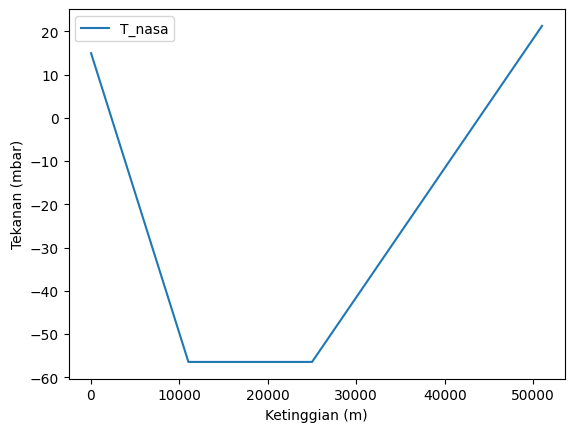

In [123]:
# T against height for 51 km
plt.plot(h_ext,T_nasa_ext, label = "T_nasa")
plt.xlabel("Ketinggian (m)")
plt.ylabel("Tekanan (mbar)")
plt.legend()
plt.show()

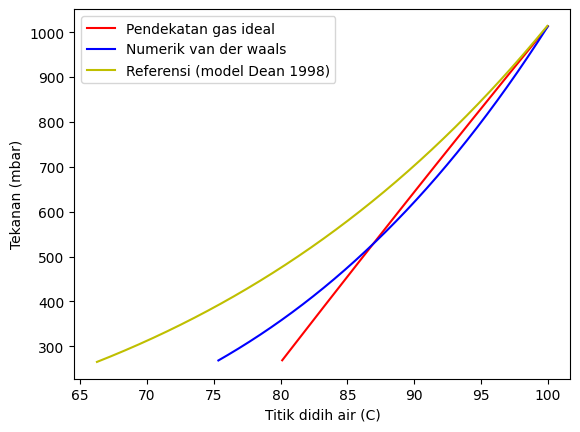

In [124]:
# Perbandingan titik didih air terhadap tekanan menurut gas ideal, van der waals, dan model dean (data)
t_dean_60up = []
for i in p_nasa:
    t_dean_60up.append(t_dean_model_60up(i))

plt.plot(t_teori,p_teori, "r", label = "Pendekatan gas ideal")
plt.plot(t,p, "b", label = "Numerik van der waals")
plt.plot(t_dean_60up, p_nasa, "y", label = "Referensi (model Dean 1998)")
plt.ylabel("Tekanan (mbar)")
plt.xlabel("Titik didih air (C)")
plt.legend()
plt.show()

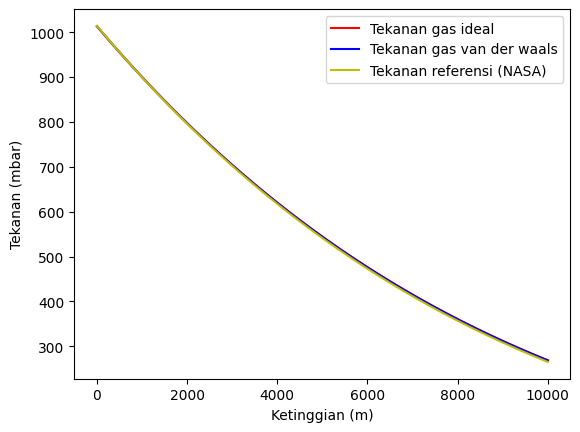

In [125]:
# PErbandingan tekanan terhadap ketinggian menurut gas ideal dengan van der waals
plt.plot(h,p_teori, "r", label = "Tekanan gas ideal")
plt.plot(h,p,"b", label = "Tekanan gas van der waals")
plt.plot(h, p_nasa, "y", label = "Tekanan referensi (NASA)")
plt.xlabel("Ketinggian (m)")
plt.ylabel("Tekanan (mbar)")
plt.legend()
plt.show()

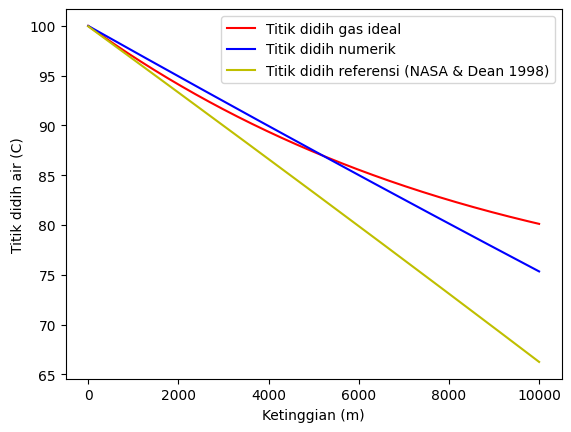

In [126]:
# Perbandingan titik didih terhadap tekanan menurut gas ideal dengan van der waals
t_dean_60up = []
for i in p_nasa:
    t_dean_60up.append(t_dean_model_60up(i))

plt.plot(h,t_teori, "r", label = "Titik didih gas ideal")
plt.plot(h,t,"b", label = "Titik didih numerik")
plt.plot(h, t_dean_60up, "y", label = "Titik didih referensi (NASA & Dean 1998)")
plt.xlabel("Ketinggian (m)")
plt.ylabel("Titik didih air (C)")
plt.legend()
plt.show()